# Physically Based Rendering In Practice

## Introduction to radiometry
* Light is measured as spectrum data
* Visible light with wavelength within 380~780nm roughly

In [ ]:
import math as math
import numpy as np
import matplotlib.pyplot as plt

def black_body_emitter(x_ary, temperature):
    h = 6.62606957e-34 
    c = 3e+8
    k = 1.3806488e-23
    y_ary = []
    for wavelength in x_ary:
        radiance = 2 * h * math.pow(c, 2) / math.pow(wavelength, 5) / (math.exp((h * c) / (wavelength * k * temperature)) - 1)
        y_ary.append(radiance)
    return y_ary

wavelengths = np.arange(100e-9, 1000e-9, 5e-9) 
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 3000), label="T=3000")
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 3500), label="T=3500")
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 4500), label="T=4500")
plt.legend(loc='lower left')
plt.show()

* Tristimulus values representation

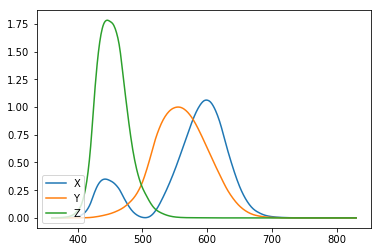

In [4]:
import CIE_XYZ_Samples as CIE_XYZ
import matplotlib.pyplot as plt

plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_X, label="X")
plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_Y, label="Y")
plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_Z, label="Z")
plt.legend(loc="lower left")
plt.show()

CIE XYZ representation:

$$X = \int_{380}^{780} S(\lambda) \overline{x}(\lambda) d\lambda$$
$$Y = \int_{380}^{780} S(\lambda) \overline{y}(\lambda) d\lambda$$
$$Z = \int_{380}^{780} S(\lambda) \overline{z}(\lambda) d\lambda$$

Chromaticity representation: CIE xyY

$$x = \frac{X}{X + Y + Z}$$
$$y = \frac{Y}{X + Y + Z}$$
$$z = \frac{Z}{X + Y + Z}$$

In [1]:
from IPython.display import SVG, display
display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/0/02/CIExy1931.svg'))

Different display devices have different characterize. 

Currently sRGB is the standard for consumer monitor, Rec.709 is for TV, sRGB and Rec.709 shared same color gamut, main difference is transfer function, sRGB transfer function usually approximated with gamma 2.2 and Rec.709 usualy use gamma 2.4. 

HDR10/Rec.2100 is another standard for consumer HDR TV with following main features:
* Rec.2020 color gamut
* 10bit color depth
* Two sets of HDR optical transfer functions which are perceptual quantization (PQ) and Hybrid Log-Gamma.

One way to convert values stored in a color gamut to another color gamut is to first reconstruct the spectrum data then project it into destinate basis function. For example, if we want to convert values in XYZ color gamut to sRGB color gamut.

$$R = \int (X \overline{x}(\lambda) + Y \overline{y}(\lambda) + Z \overline{z}(\lambda)) \overline{r}(\lambda) d{\lambda} $$
$$G = \int (X \overline{x}(\lambda) + Y \overline{y}(\lambda) + Z \overline{z}(\lambda)) \overline{g}(\lambda) d{\lambda} $$
$$B = \int (X \overline{x}(\lambda) + Y \overline{y}(\lambda) + Z \overline{z}(\lambda)) \overline{b}(\lambda) d{\lambda} $$

$$
    \begin{bmatrix}
    R \\
    G \\
    B \\
    \end{bmatrix}
    =
    \begin{pmatrix}
    {\int \overline{x}(\lambda) \overline{r}(\lambda)} &
        {\int \overline{y}(\lambda) \overline{r}(\lambda)} &
        {\int \overline{z}(\lambda) \overline{r}(\lambda)} \\
    {\int \overline{x}(\lambda) \overline{g}(\lambda)} &
        {\int \overline{y}(\lambda) \overline{g}(\lambda)} &
        {\int \overline{z}(\lambda) \overline{g}(\lambda)} \\
    {\int \overline{x}(\lambda) \overline{b}(\lambda)} &
        {\int \overline{y}(\lambda) \overline{b}(\lambda)} &
        {\int \overline{z}(\lambda) \overline{b}(\lambda)} \\
    \end{pmatrix}
    \begin{bmatrix}
    X \\
    Y \\
    Z \\
    \end{bmatrix}
$$

$$
    \begin{bmatrix}
    R \\
    G \\
    B \\
    \end{bmatrix}
    =
    \begin{pmatrix}
     3.240479 & -1.537150 & -0.498535 \\
    -0.969256 &  1.875991 &  0.041556 \\
     0.055648 & -0.204043 &  1.057311 \\
    \end{pmatrix}
    \begin{bmatrix}
    X \\
    Y \\
    Z \\
    \end{bmatrix}
$$

## Physics units in rendering pipeline

| Quantity                       | Radiometric term     | Units              |
| ------------------------------ | -------------------- | ------------------ |
| Energy                         | Radiant energy Q     | $J$ (Joule)        |
| Power                          | Radiant power P      | $W$ (Watt)         |
| Power per solid angle          | Radiant intensity I  | $\frac W {sr}$     |
| Power per area                 | Irradiance E         | $\frac W {m^2} $   |
| Power per area per solid angle | Radiance L           | $\frac W {m^2 sr}$ |

It's very important to keep coherency for physics units used in your assets. For example, some textures were authored in sRGB gamma space, some HDRI assets were made with unknown exposure settings, white balance, etc, to make them working togeter, you have to convert them into a common color gamut(sRGB is the standard for now), and make them linear. Incoherency will happen on lights also, analytical sun lights like Preetham, Hosek using radiometry units, real life lights use [photometry units](https://www.americanlightingassoc.com/Lighting-Fundamentals/Light-Sources-Light-Bulbs/New-U-S--Bulb-Packaging.aspx).

I'm using photometry units as recommended by Frosbite.

It's worth to mention that, for non-PBR, the definition of unit for light is: The color a white Lambertian surface would have when illuminated by the light from a direction parallel to the surface normal. Here are the definition in math:
$$C_{light} = \frac {1} {\pi} \int L_{i} d{w} = \frac {1} {\pi} \int E_{i} {\delta_\alpha} d{w} = \frac {E(w_i)} {\pi} $$
$$E(w_i) = C_{light} \pi$$
 

## PBR material

Reflection from surfaces can be split into four broad categories: diffuse, glossy specular, perfect specular, and retro-reflective. Most real surfaces exhibit reflection that is a mixture of these four types. Diffuse surfaces scatter light equally in all directions. Although a perfectly diffuse surface isn’t physically realizable. Glossy specular surfaces such as plastic or high-gloss paint scatter light preferentially in a set of reflected directions, they show blurry reflections of other objects. Perfect specular surfaces scatter incident light in a single outgoing direction. Mirrors and glass are examples of perfect specular surfaces. Finally, retro-reflective surfaces like velvet or the Earth’s moon scatter light primarily back along the incident direction.


![reflection](images/reflection_categories.png)

Standard PBR material trying to model diffuse and glossy specular term. For diffuse term, lambertain is used for it's simplification. Glossy specular is based on the microfacet theory. A full introduction abouht microfacet theory is beyond the scope of this note, but I can give a brief description about it. 

Glossy microfacet specular reflection BRDF is breakdown into 3 terms, Each of them trying to model different light interaction phenomenons  
* Normal distribution function
* Geometry visibility
* Fresnel

HLSL code:
```
float3 Diffuse_Lambert(float3 DiffuseColor)
{
	return DiffuseColor * DIVPI;
}

// GGX / Trowbridge-Reitz
// [Walter et al. 2007, "Microfacet models for refraction through rough surfaces"]
float D_GGX( float Roughness, float NoH )
{
	float a = Roughness * Roughness;
	float a2 = a * a;
	float d = ( NoH * a2 - NoH ) * NoH + 1;	// 2 mad
	return a2 / ( PI*d*d );					// 4 mul, 1 rcp
}

// [Schlick 1994, "An Inexpensive BRDF Model for Physically-Based Rendering"]
float3 F_Schlick( float3 SpecularColor, float VoH )
{
	float Fc = pow(1 - VoH , 5);				// 1 sub, 3 mul
	//return Fc + (1 - Fc) * SpecularColor;		// 1 add, 3 mad
	
	// Anything less than 2% is physically impossible and is instead considered to be shadowing
	return saturate( 50.0 * SpecularColor.g ) * Fc + (1 - Fc) * SpecularColor;
	
}

// Appoximation of joint Smith term for GGX
// [Heitz 2014, "Understanding the Masking-Shadowing Function in Microfacet-Based BRDFs"]
float Vis_SmithJointApprox( float Roughness, float NoV, float NoL )
{
	float a = Roughness * Roughness;
	float Vis_SmithV = NoL * ( NoV * ( 1 - a ) + a );
	float Vis_SmithL = NoV * ( NoL * ( 1 - a ) + a );
	return 0.5 * rcp( Vis_SmithV + Vis_SmithL );
}

float3 MicrofacetSpecular(float3 F0, float Roughness, float3 V, float3 N, float3 L)
{
	float3 H = normalize(V + L);
	float NdotH = saturate(dot(N, H));
	float VdotH = saturate(dot(V, H));
	float NdotL = saturate(dot(N, L));
	float NdotV = abs( dot (N, V)) + 1e-5f;

	float D = D_GGX( Roughness, NdotH );
	float Vis = Vis_SmithJointApprox( Roughness, NdotV, NdotL );
	float3 F = F_Schlick( F0, VdotH );
	return D * Vis * F;
}
```

[BRDF Explorer](https://github.com/wdas/brdf) is great tool to preview BRDF.



## PBR lights

###  Punctual light sources

Punctual light sources is a light model with following characterize.

* Classic spot/point/directional light
* Infinitely small and infinitely bright
* Greatly simplify shading equation

Let's give the derivation of reflection equation for a punctual point light:

Common reflection equation is really hard to give a analytical solution due the the complexity of BRDF:
$$L_{out} = \int_{\Omega} {F_r} {L_i} {\overline {dot}(n, l)} dw$$
    
Punctual point light intensity:
$$P = \int_{0}^{2\pi} \int_{0}^{\pi} I {d\theta} {d\phi} = {4\pi} I$$
$$I = \frac {P} {4\pi}$$
    
Punctual point light irradiance:
$$E = \frac {I} {distance^2}$$
    
Punctual point light radiance:
$$L = {E} {\delta_\alpha}$$
    
Reflection equation for punctual point light:
$$L_{out} = \int_{\Omega} {F_r} {{E} {\delta_\alpha}} {\overline {dot}(n, l)} dw$$
$$L_{out} = {F_r} {E(w_i)}{\overline {dot}(n, l)}$$
    
HLSL Code:
```
float3 diffuseBrdf = Diffuse_Lambert(gbuffer.Diffuse);
float3 specularBrdf = MicrofacetSpecular(gbuffer.Specular, gbuffer.Roughness, V, N, L);
dist = max(dist, 0.01)
float3 irradiance = radiantPower / (4 * PI) / (dist*dist)
float3 bsdf = diffuseBrdf + specularBrdf
outRadiance = bsdf * irradiance * saturate(N, L) * shadowMask
```

### Sun light

Punctual directional light is used to model the sun, then the major works is to calculate the irradiance of sun depending on the time of day. I'm using Preetham model which is a analytical solution for daytime sun light.

There are two parameters for sun radiance calculation, spherical coordinate of the sun and atmosphere turbidity. Since we know the radiance, irradiance can be evaluated with following formula:
$$solidAngle = 2 \pi (1 - cos(theta))$$
$$E = \int_\Omega L d{w_i} = L 2 \pi (1 - cos(theta))$$

Apparent radius of the sun as seen from the earth (in degrees) is approximated with 0.5358. The actual value is somewhere between 0.526 and 0.545 depending on the time of year.

Since photometry units is used, we have to convert it from radiometry to photometry.

## PBR camera

Like real life photograpy, we have to take proper exposure settings to get the resulting image.

[Understanding Exposure](https://placeholderart.wordpress.com/2014/11/16/implementing-a-physically-based-camera-understanding-exposure/) and [Manual Exposure](https://placeholderart.wordpress.com/2014/11/21/implementing-a-physically-based-camera-manual-exposure/) give a great introduction about physically based camera and some knowledge about manual exposure. Check it out if you haven't.

There are three things that can influence the exposure of a image: **Shutter Speed**, **Aperture**, and **ISO**. Each of these can be adjusted to allow more or less light in the final image. The combination of these settings is often referred to as the Exposure Value, or EV. EV has a $log_{2}$ relationship with the amount of light in the exposed image so an increase of 1 in the EV would represent a doubling of the amount of light being captured (1 EV is commonly referred to as 1 stop of light). EV is almost perceptually linear, meaning that the difference between +0 and +1 EV looks almost the same as in between +1 and +2 EV.

HLSL code:
```
// The two functions below were based on code and explanations provided by Padraic Hennessy (@PadraicHennessy).
// See this for more info: https://placeholderart.wordpress.com/2014/11/21/implementing-a-physically-based-camera-manual-exposure/

/*
* Get an exposure using the Saturation-based Speed method.
*/
float getSaturationBasedExposure(float aperture,
                                 float shutterSpeed,
                                 float iso)
{
    float l_max = (7800.0f / 65.0f) * (aperture * aperture) / (iso * shutterSpeed);
    return 1.0f / l_max;
}
 
/*
* Get an exposure using the Standard Output Sensitivity method.
* Accepts an additional parameter of the target middle grey.
*/
float getStandardOutputBasedExposure(float aperture,
                                     float shutterSpeed,
                                     float iso,
                                     float middleGrey = 0.18f)
{
    float l_avg = (1000.0f / 65.0f) * (aperture * aperture) / (iso * shutterSpeed);
    return middleGrey / l_avg;
}

float computeEV100FromAvgLuminance(float avgLuminance)
{
    // We later use the middle gray at 12.7% in order to have
    // a middle gray at 18% with a sqrt (2) room for specular highlights
    // But here we deal with the spot meter measuring the middle gray
    // which is fixed at 12.5 for matching standard camera
    // constructor settings (i.e. calibration constant K = 12.5)
    // Reference : http://en.wikipedia.org/wiki/Film_speed
    return log2(avgLuminance * 100.0f / 12.5f);
}

float convertEV100ToExposure(float EV100)
{
    // Compute the maximum luminance possible with H_sbs sensitivity
    // maxLum = 78 / ( S * q ) * N^2 / t
    // = 78 / ( S * q ) * 2^ EV_100
    // = 78 / (100 * 0.65) * 2^ EV_100
    // = 1.2 * 2^ EV
    // Reference : http://en.wikipedia.org/wiki/Film_speed
    float maxLuminance = 1.2f * pow(2.0f, EV100);
    return 1.0f / maxLuminance;
}

float Log2Exposure(in CameraSettings cameraSettings, in float avgLuminance)
{
    float exposure = 0.0f;

    if (cameraSettings.m_ExposureMode == ExposureModes_Manual_SBS)
    {
        exposure = log2(getSaturationBasedExposure(cameraSettings.m_Aperture,
                                                   cameraSettings.m_ShutterSpeed,
                                                   cameraSettings.m_ISO));
    }
    else if (cameraSettings.m_ExposureMode == ExposureModes_Manual_SOS)
    {
        exposure = log2(getStandardOutputBasedExposure(cameraSettings.m_Aperture,
                                                       cameraSettings.m_ShutterSpeed,
                                                       cameraSettings.m_ISO));
    }
    else
    {
        float autoEV100 = computeEV100FromAvgLuminance(avgLuminance);
        exposure = log2(convertEV100ToExposure(autoEV100));
    }

    return exposure;
}

// Determines the color based on exposure settings
float3 CalcExposedColor(in CameraSettings cameraSettings,
                        in float3 color,
                        in float avgLuminance,
                        in float offset,
                        out float exposure)
{
    exposure = Log2Exposure(cameraSettings, avgLuminance);
    exposure += offset;
    return exp2(exposure) * color;
}
```

## Display referred image

A display referred image is one defined by how it will be displayed. sRGB/Rec.709 for example is a display referred color space meaning, the contrast range of Rec.709 images is mapped to the contrast range of the display device, a HD television.

[The Academy Color Encoding System](http://acescentral.com/) (ACES) define a pipeline to turn digital camera captured images to final display device. It also features a carefully crafted filmic curve for displaying HDR images on LDR output devices.

![ACES](images/aces_pipeline.png)

Full ACES implementation is interesting, but I don't have time to working on it and it's a bit of overkill for me. Fortunely,  there is a [fitted curve](https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/) for sRGB monitor.